<a href="https://colab.research.google.com/github/HuangJin-De/Machine-Learning-in-Atmospheric-Thermodynamics/blob/master/hw03-1/hw03-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! rm -rf Machine-Learning-in-Atmospheric-Thermodynamics
! git clone https://github.com/HuangJin-De/Machine-Learning-in-Atmospheric-Thermodynamics.git

Cloning into 'Machine-Learning-in-Atmospheric-Thermodynamics'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (335/335), done.
remote: Compressing objects: 100% (248/248), done.
remote: Total 367 (delta 119), reused 204 (delta 47), pack-reused 32
Receiving objects: 100% (367/367), 180.35 MiB | 16.41 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split

path='Machine-Learning-in-Atmospheric-Thermodynamics/hw03'
filen=path+'/data/era5_stn_th.dat'

data=np.fromfile(filen,dtype=np.float32)
data=data.reshape(-1,17)

x=data[:,0:16]
y=data[:,16].reshape(-1,1)#.astype(int)

print(x.shape,x[1,:])
print(y.shape,y[1,:])

x_temp,x_valid,y_temp,y_valid=train_test_split(x,y,test_size=0.2,random_state=1)
x_train,x_test,y_train,y_test=train_test_split(x_temp,y_temp,test_size=0.2,random_state=1)

label_unique, counts=np.unique(y_temp,return_counts=True)
print(label_unique, counts)
weight=[sum(counts)/c for c in counts]
print(weight)

scaler=StandardScaler()
x_temp=scaler.fit_transform(x_temp)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)
x_valid=scaler.transform(x_valid)

print('finished')

(9417, 16) [326.37604 323.53775 320.28677 317.47955 315.22504 312.1862  310.70364
 309.3074  307.98483 306.47357 305.08533 303.91504 302.85    301.75815
 300.15994 299.9878 ]
(9417, 1) [0.]
[0. 1.] [2130 5403]
[3.536619718309859, 1.394225430316491]
finished


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class TrainData(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.x_data)

train_data=TrainData(torch.FloatTensor(x_train),torch.FloatTensor(y_train))
test_data=TrainData(torch.FloatTensor(x_test),torch.FloatTensor(y_test))
valid_data=TrainData(torch.FloatTensor(x_valid),torch.FloatTensor(y_valid))

BATCH_SIZE=64
weight_train=[weight[k] for k in y_train.reshape(-1).astype(int)]
sampler_train=WeightedRandomSampler(weight_train,len(y_train))
train_loader=DataLoader(dataset=train_data,sampler=sampler_train,batch_size=BATCH_SIZE)

weight_test=[weight[k] for k in y_test.reshape(-1).astype(int)]
sampler_test=WeightedRandomSampler(weight_test,len(y_test))
test_loader=DataLoader(dataset=test_data,sampler=sampler_test,batch_size=BATCH_SIZE)

valid_loader=DataLoader(dataset=valid_data,batch_size=1)

print('finished')

finished


In [4]:
from torch import nn
from torchvision.transforms import ToTensor, Lambda, Compose
import time

class BinaryClassification(nn.Module):
  def __init__(self):
    super(BinaryClassification, self).__init__()
    self.BC = nn.Sequential(
      nn.Linear(16, 128),   
      nn.ReLU(),     
      nn.BatchNorm1d(128),   
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.BatchNorm1d(128),
      nn.Dropout(p=0.1),
      nn.Linear(128, 1)
    )

  def forward(self, x):
    freq = self.BC(x)
    binary = freq #torch.round(freq)
    return binary

print('defined model')

defined model


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = BinaryClassification().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    train_loss=0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)  
        loss = loss_fn(pred, y) 
        train_loss += loss.item()

        optimizer.zero_grad()  
        loss.backward()      
        optimizer.step()      
       
        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    return train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad(): 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(torch.sigmoid(pred))==y).sum().float()

    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss

# training start
epochs=200

tt=time.time()
train_loss=[]
test_loss=[]
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    loss = train(train_loader, model, loss_fn, optimizer)
    train_loss.append(loss)
    loss = test(test_loader, model, loss_fn)
    test_loss.append(loss)

elapse=time.time()-tt
print(elapse)

torch.save(model.state_dict(),'model.pkl')

Epoch 1-------------------------------
Accuracy: 65.8%, Avg loss: 0.625636
Epoch 2-------------------------------
Accuracy: 69.3%, Avg loss: 0.595489
Epoch 3-------------------------------
Accuracy: 72.0%, Avg loss: 0.566274
Epoch 4-------------------------------
Accuracy: 69.2%, Avg loss: 0.561407
Epoch 5-------------------------------
Accuracy: 71.7%, Avg loss: 0.564823
Epoch 6-------------------------------
Accuracy: 71.7%, Avg loss: 0.552516
Epoch 7-------------------------------
Accuracy: 72.7%, Avg loss: 0.535849
Epoch 8-------------------------------
Accuracy: 73.7%, Avg loss: 0.518219
Epoch 9-------------------------------
Accuracy: 73.5%, Avg loss: 0.539327
Epoch 10-------------------------------
Accuracy: 74.1%, Avg loss: 0.519456
Epoch 11-------------------------------
Accuracy: 72.5%, Avg loss: 0.520987
Epoch 12-------------------------------
Accuracy: 75.0%, Avg loss: 0.520554
Epoch 13-------------------------------
Accuracy: 73.7%, Avg loss: 0.512264
Epoch 14-------------

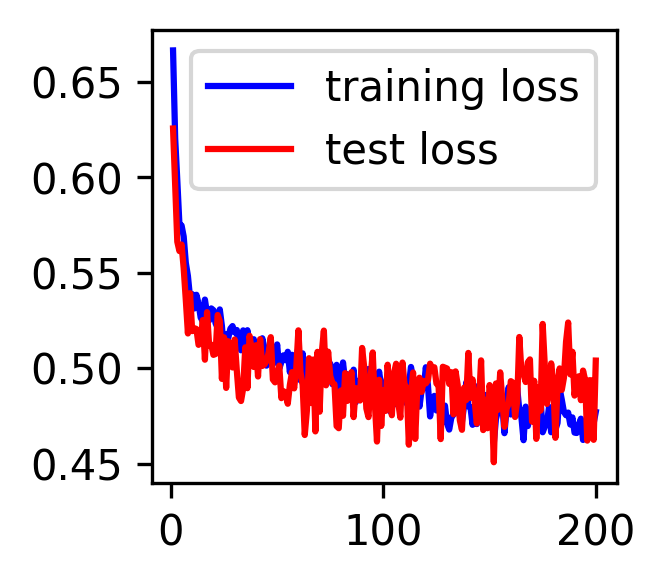

In [6]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax.plot(np.arange(1,epochs+1),train_loss,'b',np.arange(1,epochs+1),test_loss,'r')
plt.legend(["training loss","test loss"])









Accuracy is  0.7430997876857749
Precision is  0.7114093959731543
Recall is  0.9077069457659372
F1 score is  0.7976588628762541


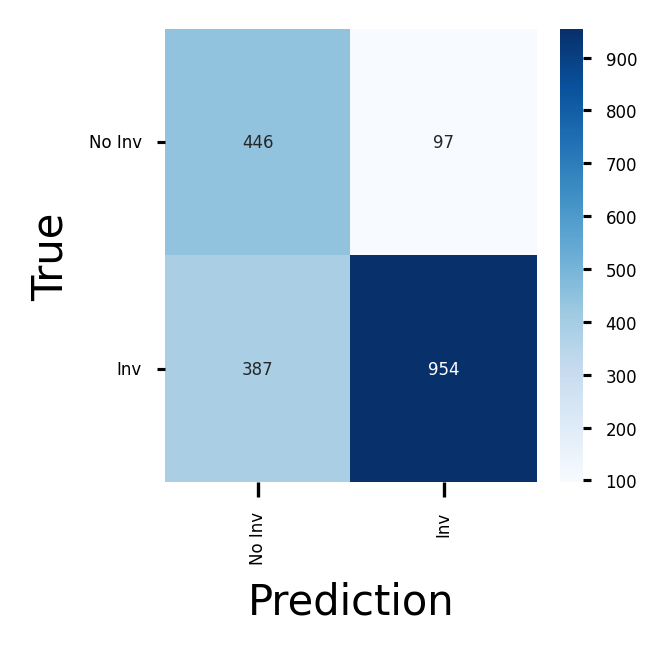

In [7]:
import seaborn as sn

model2 = BinaryClassification()
model2.load_state_dict(torch.load('model.pkl'))

classes = [
    "No Inv",
    "Inv"
]

model2.eval()

cm=np.zeros((len(classes),len(classes)))

#test_loader=DataLoader(test_data,sampler=sampler_test,batch_size=1)
for x,y in valid_loader:
  pred = model2(x)
  pred = torch.round(torch.sigmoid(pred))
  x1=pred.detach().numpy().astype(int)
  y1=y.detach().numpy().astype(int)
  cm[x1,y1]+=1
  #print(f'預測值："{pred[0].argmax(0)}" / 實際值："{y[0]}"')

plt.rcParams.update({'ytick.major.size':2,'ytick.major.width':0.75})
fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax=sn.heatmap(cm.transpose(),xticklabels=classes,yticklabels=classes,annot=True,cmap='Blues',fmt='g',annot_kws={"fontsize":4})

plt.yticks(rotation=0) 
plt.xticks(rotation=90)
sn.set(font_scale=0.5)
ax.tick_params(labelsize=4) 
ax.figure.axes[-1].tick_params(labelsize=4)
plt.xlabel('Prediction')
plt.ylabel('True')

print('\n\n\n\n\n\n\n')
print('Accuracy is ',np.diagonal(cm).sum()/cm.sum())
print('Precision is ',cm[1,1]/cm[:,1].sum())
print('Recall is ',cm[1,1]/cm[1,:].sum())
print('F1 score is ',2.*(cm[1,1]/cm[:,1].sum()*cm[1,1]/cm[1,:].sum())/(cm[1,1]/cm[:,1].sum()+cm[1,1]/cm[1,:].sum()))

torch.Size([1884, 16]) torch.Size([1884, 1])


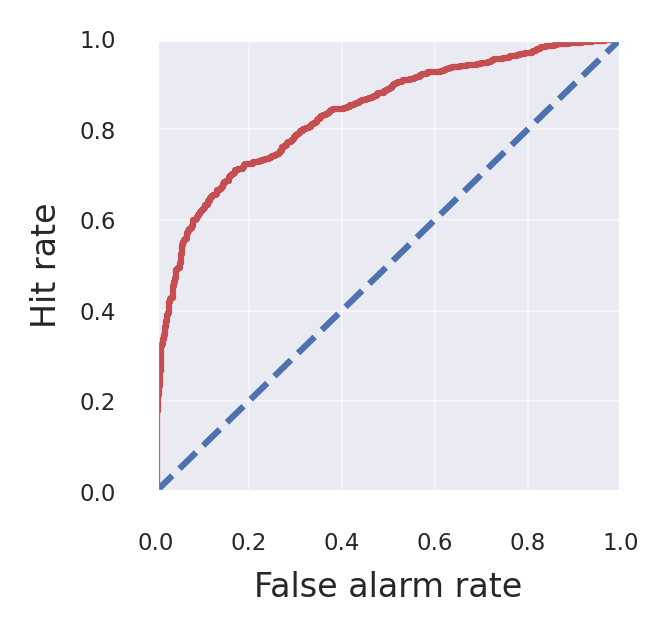

In [62]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

valid_loader=DataLoader(dataset=valid_data,batch_size=10000)
for x,y in valid_loader:
  print(x.shape,y.shape)
  pred = model2(x)
  pred = torch.sigmoid(pred)
  x1=pred.detach().numpy()
  y1=y.detach().numpy()

rocx,rocy,_=roc_curve(y1,x1)
roc_area=roc_auc_score(y1,x1)

fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax.plot(rocx,rocy,'r-',[0, 1],[0, 1],'b--')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xlabel('False alarm rate',fontsize=8)
ax.set_ylabel('Hit rate',fontsize=8)
ax.grid(lw=0.5,alpha=0.5)

[[0]] [[0]] [[1]] [[1]]


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


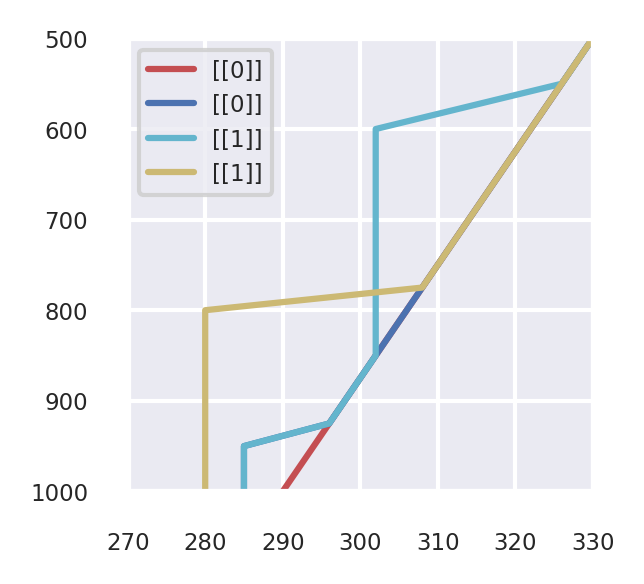

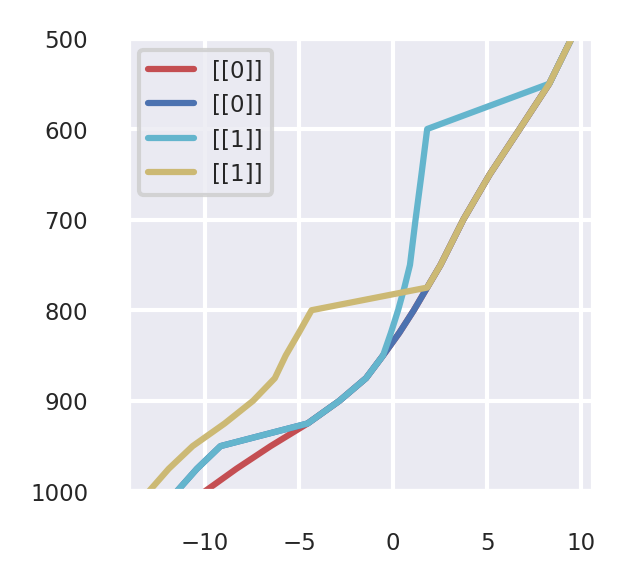

In [63]:
xx1=np.zeros(16)
xx1[0:11]=np.linspace(290.,310.,num=11)
xx1[10:16]=np.linspace(310.,330.,num=6)
xx2=np.copy(xx1)
xx2[0:3]=285.
xx3=np.copy(xx2)
xx3[6:14]=xx3[6]
xx4=np.copy(xx1)
xx4[0:9]=280.

xx11=scaler.transform(xx1.reshape(-1,16))
xx22=scaler.transform(xx2.reshape(-1,16))
xx33=scaler.transform(xx3.reshape(-1,16))
xx44=scaler.transform(xx4.reshape(-1,16))

yy1=model2(torch.FloatTensor(xx11))
yy2=model2(torch.FloatTensor(xx22))
yy3=model2(torch.FloatTensor(xx33))
yy4=model2(torch.FloatTensor(xx44))

yy1=torch.round(torch.sigmoid(yy1)).detach().numpy().astype(int)
yy2=torch.round(torch.sigmoid(yy2)).detach().numpy().astype(int)
yy3=torch.round(torch.sigmoid(yy3)).detach().numpy().astype(int)
yy4=torch.round(torch.sigmoid(yy4)).detach().numpy().astype(int)

print(yy1,yy2,yy3,yy4)

p=np.array([1000.,975.,950.,925.,900.,875.,850.,825.,800.,775.,750.,700.,650.,600.,550.,500.])

#print(p.shape,xx1.shape)

fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax.plot(xx1.reshape(-1),p,'r-',xx2.reshape(-1),p,'b-',xx3.reshape(-1),p,'c-',xx4.reshape(-1),p,'y-')
ax.set_ylim([1000,500])
ax.set_xlim([270,330])
ax.legend([yy1,yy2,yy3,yy4])

fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax.plot(xx11.reshape(-1),p,'r-',xx22.reshape(-1),p,'b-',xx33.reshape(-1),p,'c-',xx44.reshape(-1),p,'y-')
ax.set_ylim([1000,500])
#ax.set_xlim([280,330])
ax.legend([yy1,yy2,yy3,yy4])
